In [1]:
from plurals.agent import Agent
from plurals.deliberation import Chain, Debate, Ensemble
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pandas as pd
import sys 
from tqdm import tqdm
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *
import lexical_diversity

import numpy as np
from sklearn.metrics import pairwise_distances
from sentence_transformers import SentenceTransformer

# semantic distnace model 
# MODEL = SentenceTransformer('all-mpnet-base-v2')

/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read in political issues

In [37]:

# Parameters
###################
model = "gpt-4o"
n_words = 100
n_issues = 4
n_per_block = 30
fn = f"../data/raw/{n_words}words_{n_issues}issues_{n_per_block}iters_{model}_pol_responses.csv"
###################

# Read in issues
###################
pol_issues = pd.read_csv("../data/raw/2024-08-08_isidewith_political_issues_popular.csv")
issues = pol_issues.sort_values(by=['initial_order'], ascending=True).head(n_issues)
issues['description_instructions'] = issues['question'] + " " + "Answer in {} words with a rationale.".format(n_words)
issues.to_csv("../data/processed/issue_prompts.csv")
issues_json = issues[['issue', 'description_instructions']].to_json(orient='records')
###################



# Generate responses
###################
data = []
agent_types = {
        'persona_conservative': {"ideology": "conservative"},
        'persona_liberal': {"ideology": "liberal"}, 
        'default_conservative': {"ideology": "conservative"},
        'default_liberal': {"ideology": "liberal"},
}

total_iters = n_issues * n_per_block * len(agent_types)
used_personas = set()
with tqdm(total=total_iters) as pbar:
    counter = 0
    for idx, row in issues.iterrows():
        topic = row['issue']
        prompt = row['description_instructions']
        for iter in range(n_per_block):
            for agent_type in list(agent_types.keys()):
                ideology_query = agent_types[agent_type]['ideology']
                if "persona_" in agent_type:
                    fresh_persona = False
                    while not fresh_persona:
                        agent = Agent(ideology=ideology_query, model=model, kwargs={'seed':counter})
                        if agent.persona not in used_personas:
                            fresh_persona = True             
                            used_personas.add(agent.persona)       
                else:
                    agent = Agent(system_instructions="You are a {}".format(ideology_query), model=model, kwargs={'seed':counter})
                resp = agent.process(prompt)
                data_pt = {
                    "topic": topic,
                    "agent_type": "persona" if "persona_" in agent_type else "default",
                    "ideology": ideology_query,
                    "prompt": prompt,
                    "response": resp, 
                    "iter": iter, 
                    "system_instructions": agent.system_instructions,
                }
                data.append(data_pt)
                counter += 1
                pbar.update(1)

resp_df = pd.DataFrame(data)
resp_df.to_csv(fn)
###################

  1%|          | 4/480 [00:05<10:42,  1.35s/it]

In [2]:
resp_df = pd.DataFrame(data)
resp_df.to_csv("resp_df.csv")

NameError: name 'data' is not defined

In [3]:
resp_df = pd.read_csv("resp_df.csv")

In [144]:
import numpy as np
import pandas as pd
import nltk
from nltk.util import ngrams
from sklearn.utils import resample
import joblib
from tqdm.auto import tqdm
from lexical_diversity import lex_div as ld
import os

def generate_ngrams(text, ngram_lengths, cut_at=None):
    """
    Generates ngrams for a given text and ngram lengths using nltk word_tokenize.

    Args:
        text (str): The text to generate ngrams for.
        ngram_lengths (list): A list of integers specifying the ngram lengths to generate.
        
    Returns:
        list: A list of ngrams for the given text and ngram lengths.
    """
    words = nltk.word_tokenize(text)
    if cut_at:
        words = words[:cut_at]
    return [' '.join(ngram) for n in ngram_lengths for ngram in ngrams(words, n)]

def type_token_ratio(units):
    """
    Returns the type-token ratio for a list of units, which is the number of unique units divided by the total number of units.

    Args:
        units (list): A list of units (words or ngrams).

    Returns:
        float: The type-token ratio.
    """
    return len(set(units)) / len(units)


def compute_diversity_metrics(grams):
    """
    Compute diversity metrics for multiple n-grams.

    Args:
        grams (dict): A dictionary with n-gram counts for each n-gram level.

    Returns:
        list: A list of dictionaries with metrics results.
    """
    results = []
    for n, gram_data in grams.items():
        ttr = type_token_ratio(gram_data)
        results.append({'metric': f'TTR-{n}', 'mean':ttr})
        hdd = ld.hdd(gram_data)
        results.append({'metric': f'HDD-{n}', 'mean':hdd})
    return results

def process_data(resp_df):
    """
    Apply n-gram generation to DataFrame and compute metrics.

    Args:
        resp_df (DataFrame): A DataFrame with a 'response' column containing text data.

    Returns:
        DataFrame: A DataFrame containing computed metrics.
    """
    ngram_lengths = [1, 2, 3,4,5]
    for n in ngram_lengths:
        resp_df[f'{n}_gram'] = resp_df['response'].apply(lambda x: generate_ngrams(x, [n]))
    
    grouped = resp_df.groupby(['topic', 'agent_type', 'ideology'])
    results = []

    for (topic, agent, ideology), group in grouped:
        grams = {n: [token for sublist in group[f'{n}_gram'] for token in sublist] for n in ngram_lengths}
        metrics = compute_diversity_metrics(grams)
        for metric in metrics:
            metric.update({'topic': topic, 'agent_type': agent, 'ideology': ideology})
            results.append(metric)
    return pd.DataFrame(results)


resp_df = pd.read_csv("resp_df.csv")
final_df = process_data(resp_df)


/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_86806/2718837055.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains('TTR')],
/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_86806/2718837055.py:12: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains('TTR')],


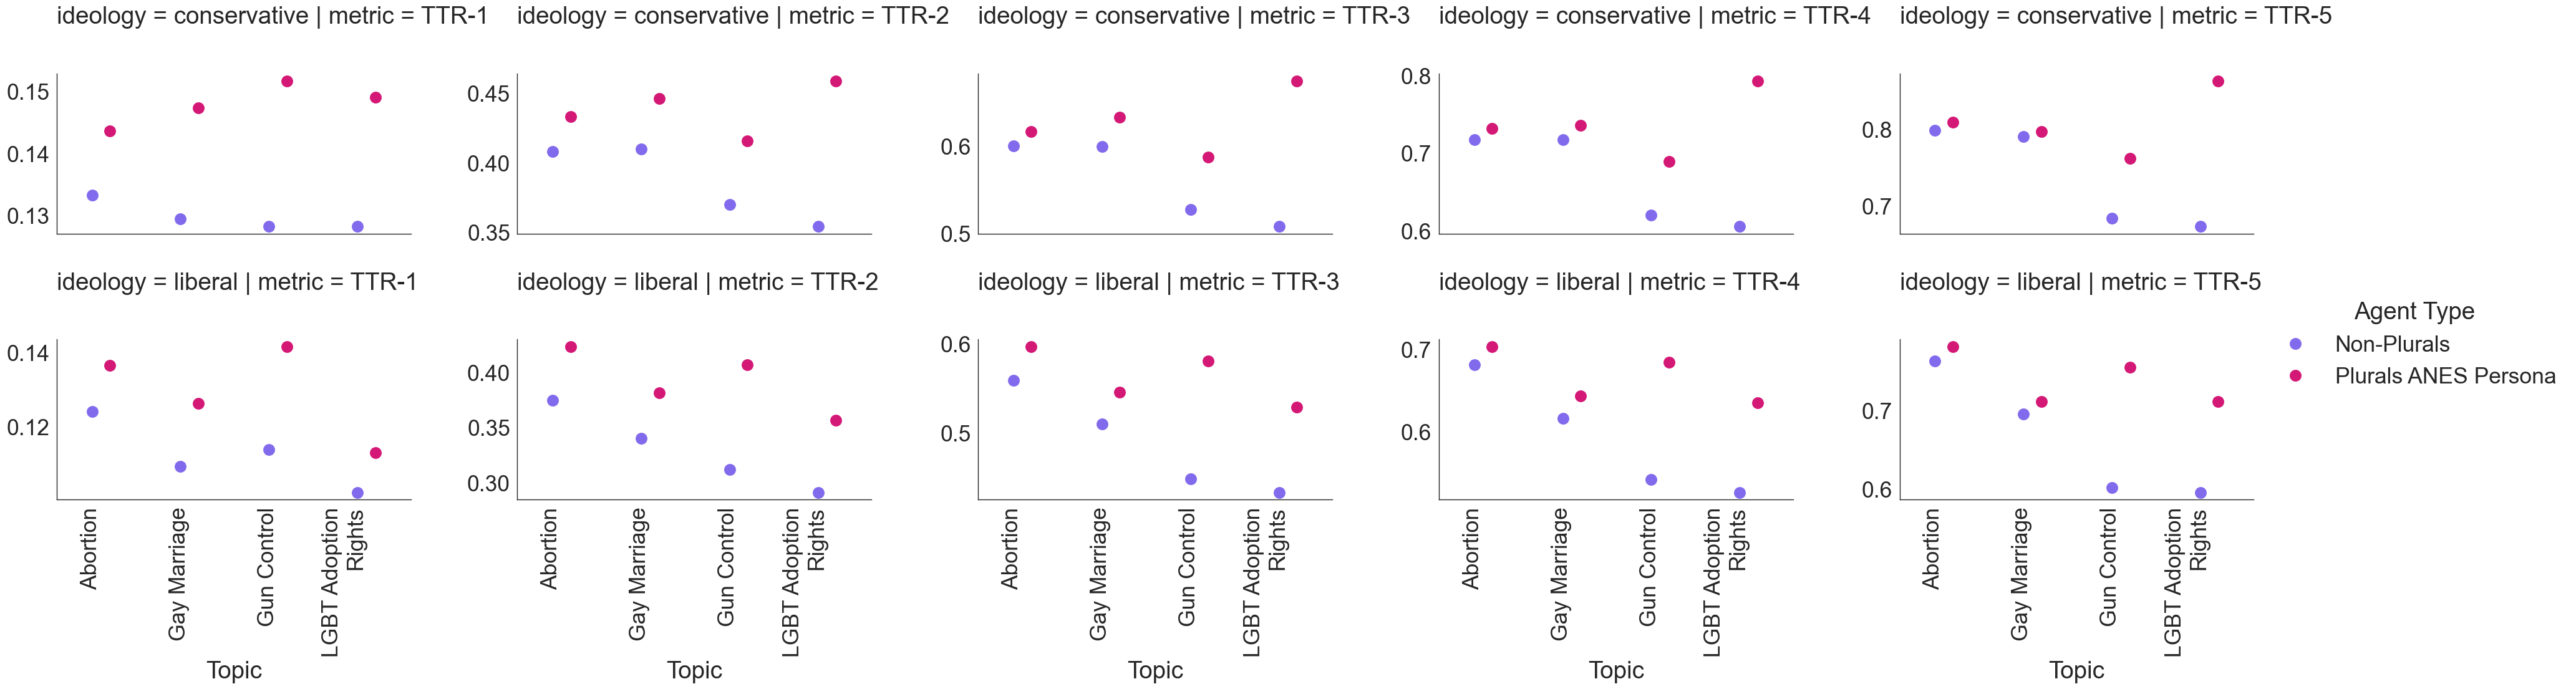

In [145]:
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



final_df['topic2'] = final_df['topic'].apply(lambda x: "LGBT Adoption\nRights" if x == "LGBT Adoption Rights" else x)
final_df['Agent Type'] = final_df['agent_type'].apply(lambda x: "Plurals ANES Persona" if x == "persona" else "Non-Plurals")
# Create the point plot
ax = sns.catplot(data=final_df[final_df['metric'].str.contains('TTR')], 
                   y='mean', 
                   x='topic2',
                   kind='point',
                   hue='Agent Type', 
                   col='metric',
                   sharey=False,
                   join=False,
                   markersize=12,
                   row='ideology',
                   aspect=1.5,
                   dodge=0.2,
                   ci=None)


for ax in ax.axes.flat:
    ax.set_xlabel('Topic')
    ax.set_ylabel('')
    # rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_ha('right')

plt.savefig("../plots/lexical_diversity.pdf", dpi=300, bbox_inches='tight')

# Lexical metrics

In [153]:
lex_data = []
metrics = [x for x in final_df['metric'].unique()]
for topic in final_df['topic'].unique():
    for ideology in final_df['ideology'].unique():
        tdf = final_df[(final_df['topic'] == topic) & (final_df['ideology'] == ideology)]
        plurals_value = tdf[tdf['agent_type'] == 'persona']['mean'].mean()
        non_plurals_value = tdf[tdf['agent_type'] == 'default']['mean'].mean()
        for metric in metrics:
            lex_data.append({
                'topic': topic,
                'ideology': ideology,
                'metric': metric,
                'plurals': plurals_value,
                'non_plurals': non_plurals_value
            })
lex_df = pd.DataFrame(lex_data)
lex_df['greater'] = (lex_df['plurals'] > lex_df['non_plurals']).astype(int)
lex_df['metric_type'] = lex_df['metric'].apply(lambda x: x.split("-")[0])

In [155]:
lex_df['greater'].sum()

80

# WC Lengths

In [179]:
from scipy.stats import ttest_ind



resp_df['wc'] = resp_df['response'].apply(lambda x: len(generate_ngrams(x, [1])))
persona_wc = resp_df[resp_df['agent_type'] == 'persona']['wc']
default_wc = resp_df[resp_df['agent_type'] == 'default']['wc']



plurals_stats = pretty_print_desc_stats(persona_wc, n_digits=1)
non_plurals_stats = pretty_print_desc_stats(default_wc, n_digits=1)

t_test = ttest_ind(persona_wc, default_wc)
t, p = t_test.statistic, t_test.pvalue
print(t,p)

s = (
    f"Differences in word counts for Plurals ({plurals_stats}) and Non-Plurals ({non_plurals_stats}) "
    f"responses were small in magnitude but statistically significant (t({len(persona_wc) + len(default_wc) - 2}) = "
    f"{t:.2f}, p < 0.05)."
)

print(s)


-3.176690714373554 0.001586028924300724
Differences in word counts for Plurals ($M = 104.8, Mdn = 106.0, SD = 7.2$) and Non-Plurals ($M = 106.7, Mdn = 107.0, SD = 6.1$) responses were small in magnitude but statistically significant (t(478) = -3.18, p < 0.05).
